In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
test_data = pd.read_hdf("../circles.h5", "true_circle")
test_data.index.name = "time"

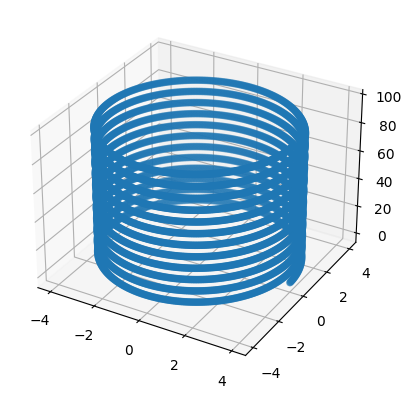

In [3]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(test_data.position.x, test_data.position.y, test_data.index)

In [4]:
tables={}
names = ["true_circle"]
timestep_bases = [1, 2, 5]
# timestep_magnitudes = [0.001, 0.01, 0.1, 1, 10]
timestep_magnitudes = [0.01, 0.1, 1, 10]
timesteps = []
for magnitude in timestep_magnitudes:
    for base in timestep_bases:
        timesteps.append(base*magnitude)

for timestep in timesteps:
    names.append(f"ts_{int(1000*timestep)}")
for name in names:
    tables[name] = pd.read_hdf("../circles.h5", name)
    print(f"{name}: \n{tables[name].head()}")

true_circle: 
vector     position                 velocity               
component         x         y    z         x         y    z
0.00       4.000000  0.000000  0.0 -0.000000  3.141593  0.0
0.02       3.999507  0.062829  0.0 -0.049346  3.141205  0.0
0.04       3.998026  0.125643  0.0 -0.098680  3.140042  0.0
0.06       3.995559  0.188426  0.0 -0.147989  3.138105  0.0
0.08       3.992107  0.251162  0.0 -0.197262  3.135393  0.0
ts_10: 
vector     position                 velocity               
component         x         y    z         x         y    z
0.00000    4.000000  0.000000  0.0  0.000000  3.141593  0.0
0.02000    3.999507  0.062829  0.0 -0.049346  3.141205  0.0
0.04000    3.998026  0.125643  0.0 -0.098680  3.140043  0.0
0.06001    3.995558  0.188457  0.0 -0.148014  3.138105  0.0
0.08000    3.992107  0.251162  0.0 -0.197262  3.135394  0.0
ts_20: 
vector     position                 velocity               
component         x         y    z         x         y    z
0.00000   

In [5]:
for name in names:
    table = tables[name]
    table["rad"] = table.apply(lambda row: np.hypot(row.position.x, row.position.y), axis=1)

In [6]:
tables["ts_200"].tail()

vector     position                 velocity                      rad
component         x         y    z         x         y    z          
95.9202    3.043715 -2.667526  0.0  2.058495  2.348629  0.0  4.047208
95.9402    3.084521 -2.620237  0.0  2.022003  2.380122  0.0  4.047210
95.9602    3.124592 -2.572324  0.0  1.985028  2.411048  0.0  4.047212
95.9802    3.163919 -2.523799  0.0  1.947581  2.441400  0.0  4.047214
96.0002    3.202492 -2.474672  0.0  1.909669  2.471170  0.0  4.047216

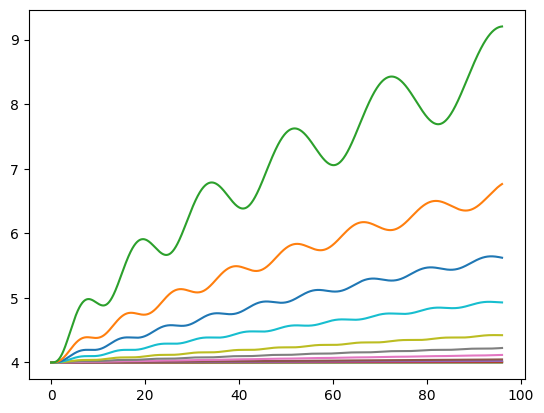

In [7]:
fig, ax = plt.subplots()
for name in names:
    table = tables[name]
    ax.plot(table.rad)

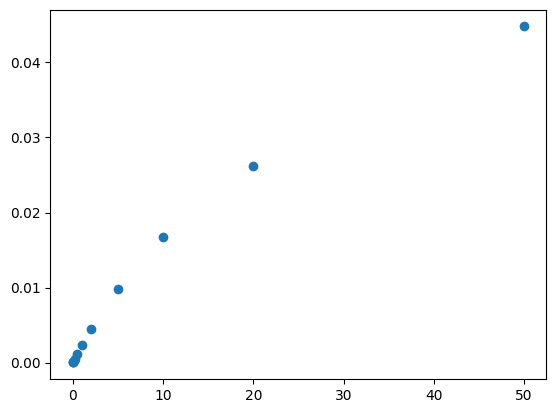

In [8]:
# looking above, while there's some weird "bobble" to the changes of radius, it's
# not too bad to just do a linear fit to them, and look at slope. Then slope against
# timestep should give us a reasonable estimation of error

slopes = []
for timestep in timesteps:
    name = f"ts_{int(1000*timestep)}"
    table = tables[name]
    regression = linregress(table.index, table.rad)
    slopes.append(regression.slope)
plt.scatter(timesteps, slopes)


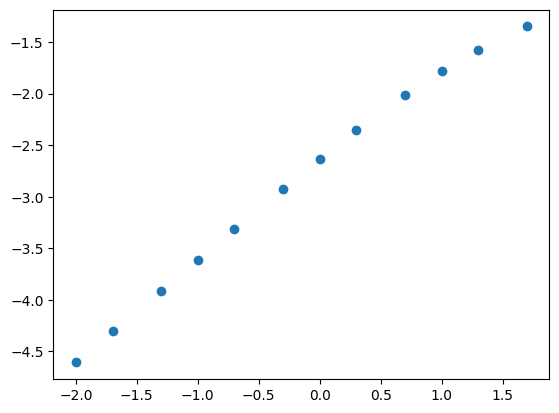

In [9]:
# looks maybe logarithmic, or maybe 1/x^2 or something.
# plt.scatter(np.log10(timesteps))
plt.scatter(np.log10(timesteps), np.log10(slopes))

In [19]:
# not perfectly linear in logxlog space, but probably close enough to get a result
reg = linregress(np.log10(timesteps), np.log10(slopes))
# print(reg.slope, reg.intercept)
# log10(slopes) = reg.slope*log10(timestep) + reg.intercept
# slope is (average) increase in radial error over time
# to find a timestep for a threshold value of error, invert the regression
inv_reg = linregress(np.log10(slopes), np.log10(timesteps))


0.0011104380758484424


In [23]:
# then use the values to solve for a timestamp:
threshold_precision = 4e-6 # using 4 since base radial value is 4, and we want 1 in 10^6 precision, say
threshold_timestep_l10 = inv_reg.slope*np.log10(threshold_precision) + inv_reg.intercept
threshold_timestep = np.power(10, threshold_timestep_l10)
print(threshold_timestep)
# 1 microsecond gets us approximately ppm position resolution.
# since it's log scale, 10 µs -> 10 ppm, 0.1 ms -> 100 ppm etc. (roughly)

0.0011104380758484424
